# AWS SETUP  

In this notebook, we will use an sdk python library called "boto3" to create Redshift cluster and explore the the data in S3 bucket to further create ETL pipelines and DB objects. 

## (Prerequisite) Save the AWS Access key: 

### 1. Create a new IAM user
IAM service is a global service, meaning newly created IAM users are not restricted to a specific region by default.
- Go to [AWS IAM service](https://console.aws.amazon.com/iam/home#/users) and click on the "**Add user**" button to create a new IAM user in your AWS account. 
- Choose a name of your choice. 
- Select "*Programmatic access*" as the access type. Click Next. 
- Choose the *Attach existing policies directly* tab, and select the "**AdministratorAccess**". Click Next. 
- Skip adding any tags. Click Next. 
- Review and create the user. It will show you a pair of access key ID and secret.
- Take note of the pair of access key ID and secret. This pair is collectively known as **Access key**. 

<center>
<img style="float: center;height:300px;" src="images/AWS_IAM_1.png"><br><br>
Snapshot of a pair of an Access key
</center>

### <font color='red'>2. Save the access key and secret</font>
Edit the file `dwh.cfg` in the same folder as this notebook and save the access key and secret against the following variables:
```bash
KEY= <YOUR_AWS_KEY>
SECRET= <YOUR_AWS_SECRET>
```

# Creating Redshift Cluster using the AWS python SDK 
We will perform the following steps.  
- make a DWH.cfg file containg all configuration parameters. 
- create EC2 and S3 resource objects and also the client IAM and Redshift cluster objects to connect to resources 
- Create an IAM Role that makes Redshift able to access S3 bucket (ReadOnly) and attach policy and get IAM role ARN (Amazon Resource Names (ARNs) uniquely identify AWS resources)
- Create a RedShift Cluster.
- Open an incoming  TCP port to access the cluster ednpoint
- connect to the cluster database

In [197]:
# import required libraries 
import pandas as pd
import boto3
import json

In [ ]:
%load_ext sql

## Load DWH Params from dwh_init.cfg 
- The file is blank for security_purpose.
- Fill yours AWS key account ( put these blank when in apublic repo) and userdefined parameters

In [ ]:
import configparser

# make parsing object
config = configparser.ConfigParser()
config.read_file(open('dwh_init.cfg'))

# get keys with AWS block
KEY                    = config.get('AWS','KEY')
SECRET                 = config.get('AWS','SECRET')

# get keys with CLUSTER block
DWH_CLUSTER_TYPE       = config.get("CLUSTER","DWH_CLUSTER_TYPE")
DWH_NUM_NODES          = config.get("CLUSTER","DWH_NUM_NODES")
DWH_NODE_TYPE          = config.get("CLUSTER","DWH_NODE_TYPE")

DWH_CLUSTER_IDENTIFIER = config.get("CLUSTER","DWH_CLUSTER_IDENTIFIER")
DWH_DB                 = config.get("CLUSTER","DWH_DB")
DWH_DB_USER            = config.get("CLUSTER","DWH_DB_USER")
DWH_DB_PASSWORD        = config.get("CLUSTER","DWH_DB_PASSWORD")
DWH_PORT               = config.get("CLUSTER","DWH_PORT")

DWH_IAM_ROLE_NAME      = config.get("CLUSTER", "DWH_IAM_ROLE_NAME")

# get key from S3 block
LOG_DATA              = config.get("S3", "LOG_DATA")
SONG_DATA             = config.get("S3", "SONG_DATA")
LOG_JSONPATH          = config.get("S3", "LOG_JSONPATH")

# Make a DataFrame
pd.DataFrame({"Parameters":["DWH_CLUSTER_TYPE", "DWH_NUM_NODES", "DWH_NODE_TYPE", "DWH_CLUSTER_IDENTIFIER", "DWH_DB", "DWH_DB_USER", "DWH_DB_PASSWORD", "DWH_PORT", "DWH_IAM_ROLE_NAME"], 
              "Values":[DWH_CLUSTER_TYPE, DWH_NUM_NODES, DWH_NODE_TYPE, DWH_CLUSTER_IDENTIFIER, DWH_DB, DWH_DB_USER, DWH_DB_PASSWORD, DWH_PORT, DWH_IAM_ROLE_NAME]
             })


## Create resource objects for EC2, S3, and client objects for IAM, and Redshift

In [200]:
import boto3

ec2 = boto3.resource('ec2',
                      region_name="us-west-2",
                      aws_access_key_id=KEY,
                      aws_secret_access_key=SECRET
                    )

s3 = boto3.resource('s3',
                     region_name="us-west-2",
                     aws_access_key_id=KEY,
                     aws_secret_access_key=SECRET
                   )

iam = boto3.client('iam',
                    region_name="us-west-2",
                    aws_access_key_id=KEY,
                    aws_secret_access_key=SECRET
                  )

redshift = boto3.client('redshift',
                         region_name="us-west-2",
                         aws_access_key_id=KEY,
                         aws_secret_access_key=SECRET
                       )

## connection to the S3 bucket

In [201]:
dataset_bucket =  s3.Bucket("udacity-dend")

In [202]:
dataset_bucket.objects

s3.Bucket.objectsCollectionManager(s3.Bucket(name='udacity-dend'), s3.ObjectSummary)

#### Above code shows we are able to access the s3 bucket 'udacity-dend'. can be shown with s3.Bucket.objects.all()

## Implement the logic in etl.py to load data from S3 to `staging tables` on Redshift.

###  Analysis of log_data and song_data files 

### staging tables names:
- staging_events_table_create, 
- staging_songs_table_create

#### Download a sample key object files from S3 to local for analysis 

In [203]:
!touch ./data/log_file
!touch ./data/song_file
!touch ./data/log_json_path.json

In [204]:
with open('./data/log_file', 'wb') as data:
    dataset_bucket.download_fileobj('log-data/2018/11/2018-11-01-events.json', data)

In [205]:
with open('./data/song_file', 'wb') as data:
    dataset_bucket.download_fileobj('song-data/A/A/A/TRAAAAK128F9318786.json', data)

In [206]:
with open('./data/log_json_path.json', 'wb') as data:
    dataset_bucket.download_fileobj('log_json_path.json', data)

### Use pandas for the analysis of file data types for use in staging Table creation 
- To check the datatypes in staging tables
- for also be used in data modelling in Star schema

In [207]:
import pandas as pd
df_log = pd.read_json('./data/log_file', lines= True)

In [ ]:
df_log.head()

In [209]:
df_log.isnull().sum() == 0 # shows of only one Json file

artist           False
auth             True 
firstName        True 
gender           True 
itemInSession    True 
lastName         True 
length           False
level            True 
location         True 
method           True 
page             True 
registration     True 
sessionId        True 
song             False
status           True 
ts               True 
userAgent        True 
userId           True 
dtype: bool

In [210]:
df_log.dtypes

artist           object 
auth             object 
firstName        object 
gender           object 
itemInSession    int64  
lastName         object 
length           float64
level            object 
location         object 
method           object 
page             object 
registration     int64  
sessionId        int64  
song             object 
status           int64  
ts               int64  
userAgent        object 
userId           int64  
dtype: object

#### for song_dataset 

In [211]:
df_song = pd.read_json('./data/song_file', lines= True)

In [212]:
df_song.head()

,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,num_songs,song_id,title,year
0,ARJNIUY12298900C91,NaN,,NaN,Adelitas Way,213.9424,1,SOBLFFE12AF72AA5BA,Scream,2009


In [213]:
df_song.isnull().sum() == 0 # shows of only one Json file

artist_id           True 
artist_latitude     False
artist_location     True 
artist_longitude    False
artist_name         True 
duration            True 
num_songs           True 
song_id             True 
title               True 
year                True 
dtype: bool

In [214]:
df_song.dtypes

artist_id           object 
artist_latitude     float64
artist_location     object 
artist_longitude    float64
artist_name         object 
duration            float64
num_songs           int64  
song_id             object 
title               object 
year                int64  
dtype: object

## Make connecection with Redshift Cluster

#### STEP 1: IAM ROLE
- Create an IAM Role that makes Redshift able to access S3 bucket (ReadOnly)

In [ ]:
from botocore.exceptions import ClientError

#1.1 Create the role, 
try:
    print("1.1 Creating a new IAM Role") 
    dwhRole = iam.create_role(
        Path='/',
        RoleName=DWH_IAM_ROLE_NAME,
        Description = "Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {'Statement': [{'Action': 'sts:AssumeRole',
               'Effect': 'Allow',
               'Principal': {'Service': 'redshift.amazonaws.com'}}],
             'Version': '2012-10-17'})
    )    
except Exception as e:
    print(e)
    
    
print("1.2 Attaching Policy")

iam.attach_role_policy(RoleName=DWH_IAM_ROLE_NAME,
                       PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
                      )['ResponseMetadata']['HTTPStatusCode']

print("1.3 Get the IAM role ARN")
roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

print(roleArn)

### STEP 2:  Redshift Cluster

- Create a [RedShift Cluster](https://console.aws.amazon.com/redshiftv2/home)
- For complete arguments to `create_cluster`, see [docs](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/redshift.html#Redshift.Client.create_cluster)

In [216]:
try:
    response = redshift.create_cluster(        
        #HW
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,
        NumberOfNodes=int(DWH_NUM_NODES),

        #Identifiers & Credentials
        DBName=DWH_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=DWH_DB_USER,
        MasterUserPassword=DWH_DB_PASSWORD,
        
        #Roles (for s3 access)
        IamRoles=[roleArn]  
    )
except Exception as e:
    print(e)

#### 2.1 Describe the cluster to see its status
- run this block several times until the cluster status becomes `Available`

In [ ]:
def prettyRedshiftProps(props):
    pd.set_option('display.max_colwidth', -1)
    keysToShow = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']
    x = [(k, v) for k,v in props.items() if k in keysToShow]
    return pd.DataFrame(data=x, columns=["Key", "Value"])

myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
prettyRedshiftProps(myClusterProps)

In [219]:
redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]['ClusterStatus']

'available'

<h2> 2.2 Take note of the cluster <font color='red'> endpoint and role ARN </font> </h2>

<font color='red'>DO NOT RUN THIS unless the cluster status becomes "Available". Make sure you are checking the Amazon Redshift cluster in the **us-west-2** region. </font>

In [ ]:
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']
print("DWH_ENDPOINT :: ", DWH_ENDPOINT)
print("DWH_ROLE_ARN :: ", DWH_ROLE_ARN)

### STEP 3: Open an incoming  TCP port to access the cluster ednpoint

In [ ]:
try:
    vpc = ec2.Vpc(id=myClusterProps['VpcId'])
    defaultSg = list(vpc.security_groups.all())[0]
    print(defaultSg)
    defaultSg.authorize_ingress(
        GroupName=defaultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort=int(DWH_PORT),
        ToPort=int(DWH_PORT)
    )
except Exception as e:
    print(e)

# <font color='red'> Please Note</font>:  The below steps of this notebook are for analysis purpose for designing Table structures. The final analytics table and staging table structure is then included in sql_queries.py file of the project.  
## <font color='red'>To delete cluster and release resoures, please go to the end of the file. </font>
#  <font color='red'>  Please run create_tables.py and etl.py in console for the project.</font>

# Table design analysis 
## connect to the cluster

In [ ]:
conn_string="postgresql://{}:{}@{}:{}/{}".format(DWH_DB_USER, DWH_DB_PASSWORD, DWH_ENDPOINT, DWH_PORT,DWH_DB)
print(conn_string)
%sql $conn_string

## ETL : Load data from S3 to staging tables on Redshift.

### Create staging Tables

In [ ]:
%%sql
DROP TABLE IF EXISTS staging_events_tbl;

CREATE TABLE IF NOT EXISTS staging_events_tbl (
artist           VARCHAR,
auth             VARCHAR,
firstName        VARCHAR,
gender           CHAR(1),
itemInSession    INTEGER,
lastName         VARCHAR,
length           DOUBLE PRECISION,
level            VARCHAR(4),
location         VARCHAR,
method           CHAR(3),
page             VARCHAR,
registration     BIGINT,
sessionId        INTEGER,
song             VARCHAR,
status           INTEGER,
ts               BIGINT,
userAgent        VARCHAR,
userId           INTEGER
);

DROP TABLE IF EXISTS staging_songs_tbl;

CREATE TABLE IF NOT EXISTS staging_songs_tbl (
artist_id           VARCHAR,
artist_latitude     DOUBLE PRECISION,
artist_location     VARCHAR,
artist_longitude    DOUBLE PRECISION,
artist_name         VARCHAR,
duration            DOUBLE PRECISION,
num_songs           INTEGER,
song_id             VARCHAR, 
title               VARCHAR,
year                INTEGER
);

### Load data into the staging tables in the cluster

#### STEP 1: Get the params of the created redshift cluster
- We need:
    - The redshift cluster <font color='red'>endpoint</font>
    - The <font color='red'>IAM role ARN</font> that give access to Redshift to read from S3

https://docs.aws.amazon.com/redshift/latest/dg/r_COPY_command_examples.html#copy-from-json-examples-using-jsonpaths  


In [ ]:
staging_events_copy = """
    copy staging_events_tbl
    from {0}
    credentials 'aws_iam_role={1}'
    json {2} 
    region 'us-west-2'
""".format(LOG_DATA, DWH_ROLE_ARN, LOG_JSONPATH )

%sql $staging_events_copy

In [ ]:
staging_songs_copy = """
    copy staging_songs_tbl
    from {0}
    credentials 'aws_iam_role={1}'
    json 'auto' 
    region 'us-west-2'
""".format(SONG_DATA, DWH_ROLE_ARN)

%sql $staging_songs_copy

In [ ]:
%sql select * from staging_events_tbl limit 10;

In [ ]:
%sql select * from staging_songs_tbl limit 10;

##  Analysis of staging tables  

### Anlysis for staging songs Table

In [ ]:
%sql select max(len(artist_id)) from staging_songs_tbl;

In [ ]:
%sql select max(len(song_id)) from staging_songs_tbl;

In [ ]:
%sql select max(artist_longitude), max(artist_latitude) from staging_songs_tbl;

In [ ]:
%sql select count(*) as artist_name_null_count from staging_songs_tbl where artist_name is NULL;

In [ ]:
%sql select count(*) as title_null_count from  staging_songs_tbl where title is NULL;

In [ ]:
%sql select count(*) as artist_id_null_count from staging_songs_tbl where artist_id is NULL;

In [ ]:
%sql select count(*) as song_id_null_count from staging_songs_tbl where song_id is NULL;

In [ ]:
%sql select count(*) as year_null_count from staging_songs_tbl where year is NULL;

In [ ]:
%sql select count(*) as duration_null_count from staging_songs_tbl where duration is NULL;

In [ ]:
%sql select count(*) as artist_latitude_null_count from staging_songs_tbl where artist_latitude is NULL;

In [ ]:
%sql select count(*) as artist_longitude_null_count from staging_songs_tbl where artist_longitude is NULL;

In [ ]:
%sql select count(*) as artist_location_null_count from staging_songs_tbl where artist_location is NULL;

In [ ]:
%sql select *  from staging_songs_tbl where artist_location is NULL;

### Analysis of staging_events_tbl

##### evaluation of not null constarints for firstname, lastname, level, gender

In [ ]:
%sql select  count(*) from staging_events_tbl where firstname is null and userid is not NULL;

In [ ]:
%sql select  count(*) from staging_events_tbl where lastname is null and userid is not NULL;

In [ ]:
%sql select  count(*) from staging_events_tbl where gender is null and userid is not NULL;

In [ ]:
%sql select  count(*) from staging_events_tbl where level is null and userid is not NULL;

In [ ]:
%sql select  count(*) from staging_events_tbl where sessionid is null and userid is not NULL;

In [ ]:
%sql select  count(*) from staging_events_tbl where location is null and userid is not NULL;

In [ ]:
%sql select  count(*) from staging_events_tbl where useragent in (null, 'None') and userid is not NULL;

## Create analytics tables in Redshift (no distribution strategy) in the `nodist` schema and insertion into them

In [ ]:
%%sql
CREATE SCHEMA IF NOT EXISTS nodist;
DROP TABLE IF EXISTS nodist.time;
DROP TABLE IF EXISTS nodist.artists;
DROP TABLE IF EXISTS nodist.users;
DROP TABLE IF EXISTS nodist.songs;
DROP TABLE IF EXISTS nodist.songplays; 

In [ ]:
%%sql 
CREATE TABLE IF NOT EXISTS nodist.time(
start_time        TIMESTAMP     NOT NULL, 
hour              INTEGER       NOT NULL, 
day               INTEGER       NOT NULL, 
week              INTEGER       NOT NULL, 
month             INTEGER       NOT NULL, 
year              INTEGER       NOT NULL,
weekday           INTEGER       NOT NULL
);

CREATE TABLE IF NOT EXISTS nodist.artists(
artist_id         VARCHAR(18)   NOT NULL, 
name              VARCHAR       NOT NULL,
location          TEXT,
latitude          DOUBLE PRECISION,
longitude         DOUBLE PRECISION
);

Create TABLE IF NOT EXISTS nodist.songs(
song_id           VARCHAR(18)       NOT NULL,
title             TEXT              NOT NULL, 
artist_id         VARCHAR(18)       NOT NULL,  
year              INTEGER           NOT NULL, 
duration          DOUBLE PRECISION  NOT NULL
);

CREATE TABLE IF NOT EXISTS nodist.users(
user_id           INT           NOT NULL,
first_name        VARCHAR       NOT NULL,
last_name         VARCHAR       NOT NULL,
gender            CHAR(1)       NOT NULL,
level             VARCHAR(4)    NOT NULL
);

CREATE TABLE IF NOT EXISTS nodist.songplays(
songplay_id INT IDENTITY(0,1),
start_time        TIMESTAMP     NOT NULL, 
user_id           INTEGER       NOT NULL,
level             VARCHAR(4),
song_id           VARCHAR(18),
artist_id         VARCHAR(18),
session_id        INTEGER       NOT NULL,
location          TEXT          NOT NULL,
user_agent        TEXT          NOT NULL
);


In [ ]:
%%sql
select ts, 
timestamp 'epoch' + ts/1000 * interval '1 second' as start_time
from staging_events_tbl limit 5;

In [ ]:
%%sql
INSERT INTO nodist.songplays(start_time, user_id, level, song_id, artist_id, session_id, location, user_agent)
    SELECT  DISTINCT 
            timestamp 'epoch' + stg_event.ts/1000 * interval '1 second' as start_time,
            stg_event.userid, 
            stg_event.level, 
            stg_song.song_id, 
            stg_song.artist_id, 
            stg_event.sessionid, 
            stg_event.location, 
            stg_event.useragent
    FROM staging_events_tbl as stg_event JOIN staging_songs_tbl as stg_song ON  (
            stg_event.song =  stg_song.title AND 
            stg_event.artist = stg_song.artist_name)
    WHERE 
            stg_event.userid IS NOT NULL AND 
            stg_song.song_id IS NOT NULL AND 
            stg_song.artist_id IS NOT NULL AND
            stg_event.page = 'NextSong'

In [ ]:
%%sql
INSERT INTO nodist.time(start_time, hour, day, week, month, year, weekday)
SELECT DISTINCT
    start_time,
    EXTRACT(hour    FROM start_time),
    EXTRACT(day     FROM start_time),
    EXTRACT(week    FROM start_time),
    EXTRACT(month   FROM start_time),
    EXTRACT(year    FROM start_time),
    EXTRACT(weekday FROM start_time)
FROM 
    nodist.songplays;  

In [ ]:
%%sql
INSERT INTO nodist.artists(artist_id, name, location, latitude, longitude)
SELECT DISTINCT
    artist_id,
    artist_name,
    artist_location,
    artist_latitude,
    artist_longitude
FROM
    staging_songs_tbl
WHERE 
    artist_id IS NOT NULL;

In [ ]:
%%sql
INSERT INTO nodist.users (user_id, first_name, last_name, gender, level)
SELECT DISTINCT 
    userId, 
    firstName, 
    lastName, 
    gender, 
    level
FROM 
    staging_events_tbl
WHERE 
    page = 'NextSong' AND userId IS NOT NULL;

In [ ]:
%%sql
INSERT INTO nodist.songs (song_id, title, artist_id, year, duration)
SELECT DISTINCT 
    song_id, 
    title, 
    artist_id, 
    year, 
    duration
FROM 
    staging_songs_tbl
WHERE 
    song_id IS NOT NULL

## Analysis of size of dimension table for distributed and sort key determination

In [ ]:
%sql SELECT COUNT(*) FROM nodist.time;

In [ ]:
%sql SELECT COUNT(*) FROM nodist.artists;

In [ ]:
%sql SELECT COUNT(*) FROM nodist.users;

In [ ]:
%sql SELECT COUNT(*) FROM nodist.songs;

In [ ]:
%sql SELECT COUNT(*) FROM nodist.songplays;

## Choose the best dist and sort key

https://www.sisense.com/blog/double-your-redshift-performance-with-the-right-sortkeys-and-distkeys/  

### Data redistribution

When you load data into a table, Amazon Redshift distributes the rows of the table to each of the node slices according to the table's distribution style. As part of a query plan, the optimizer determines where blocks of data need to be located to best run the query. The data is then physically moved, or redistributed, while the query runs. Redistribution might involve either sending specific rows to nodes for joining or broadcasting an entire table to all of the nodes. 



### for sort key: 
- To have Amazon Redshift choose the appropriate sort order, specify AUTO for the sort key.

- If recent data is queried most frequently, specify the timestamp column as the leading column for the sort key. Queries are more efficient because they can skip entire blocks that fall outside the time range.

- If you do frequent range filtering or equality filtering on one column, specify that column as the sort key. Amazon Redshift can skip reading entire blocks of data for that column. It can do so because it tracks the minimum and maximum column values stored on each block and can skip blocks that don't apply to the predicate range.

- If you frequently join a table, specify the join column as both the sort key and the distribution key. Doing this enables the query optimizer to choose a sort merge join instead of a slower hash join. Because the data is already sorted on the join key, the query optimizer can bypass the sort phase of the sort merge join.

###  for dist key

When you load data into a table, Amazon Redshift distributes the rows of the table to each of the node slices according to the table's distribution style. As part of a query plan, the optimizer determines where blocks of data need to be located to best run the query. The data is then physically moved, or redistributed, while the query runs. Redistribution might involve either sending specific rows to nodes for joining or broadcasting an entire table to all of the nodes. 

![Image](./images/distribution_rules.png)


#### In our case :
**Factors of deciding different distribution and sort key styles**:
- songs table and artists table
 - We have decided our disribution style as KEY distribution for song table as the Table is big with respect to other however, we have not given the required analytical queries which must decide the distribution style. Also, we can see the artist table have similar but lower size but we take as AUTO since redshift will decide which should be the best distribution style for the artist table.
 - In addition, song table cotains inherently the artist_id column as well so it should be better taken as distribution style as Key distribution. 
 - **sort key for songs table** is choosen as auto since their might be aggregations where compound keys which work better but in some case compound keys also fails (as per AWS docs). So we best choose AUTO to leave this decison on Redshift.
 - **sort key for artists table** is choosen as artist_id since it will work in agggregations and in cases without aggrgations. Year could be used but
 
- Other tables:
 - Their size is rathe small so we implemented them with "ALL distribution style".




We choose the star schema for our data modeling of Analytics tables in Redshift. Please find the complete analysis in `setup_and_analysis.ipynb` file. The below figure shows the our data model.
![Image](./images/data_model.png)`

## Create analytics tables in Redshift ( with distribution style) in the `nodist` schema and insertion into them

In [ ]:
%%sql
CREATE SCHEMA IF NOT EXISTS dist;

In [ ]:
%%sql 

DROP TABLE IF EXISTS dist.time;
DROP TABLE IF EXISTS dist.artists;
DROP TABLE IF EXISTS dist.users;
DROP TABLE IF EXISTS dist.songs;
DROP TABLE IF EXISTS dist.songplays; 

CREATE TABLE IF NOT EXISTS dist.time(
start_time        TIMESTAMP     NOT NULL   sortkey, 
hour              INTEGER       NOT NULL, 
day               INTEGER       NOT NULL, 
week              INTEGER       NOT NULL, 
month             INTEGER       NOT NULL, 
year              INTEGER       NOT NULL,
weekday           INTEGER       NOT NULL)
DISTSTYLE ALL;

CREATE TABLE IF NOT EXISTS dist.artists(
artist_id         VARCHAR(18)   NOT NULL   sortkey, 
name              VARCHAR       NOT NULL,
location          TEXT,
latitude          DOUBLE PRECISION,
longitude         DOUBLE PRECISION)
DISTSTYLE ALL;

Create TABLE IF NOT EXISTS dist.songs(
song_id           VARCHAR(18)       NOT NULL   distkey,
title             TEXT              NOT NULL, 
artist_id         VARCHAR(18)       NOT NULL,  
year              INTEGER           NOT NULL, 
duration          DOUBLE PRECISION  NOT NULL)
SORTKEY AUTO;

CREATE TABLE IF NOT EXISTS dist.users(
user_id           INT           NOT NULL   sortkey,
first_name        VARCHAR       NOT NULL,
last_name         VARCHAR       NOT NULL,
gender            CHAR(1)       NOT NULL,
level             VARCHAR(4)    NOT NULL)
DISTSTYLE ALL;

CREATE TABLE IF NOT EXISTS dist.songplays(
songplay_id INT IDENTITY(0,1)   NOT NULL,
start_time        TIMESTAMP     NOT NULL, 
user_id           INTEGER       NOT NULL,
level             VARCHAR(4),
song_id           VARCHAR(18)   distkey,
artist_id         VARCHAR(18),
session_id        INTEGER       NOT NULL,
location          TEXT          NOT NULL,
user_agent        TEXT          NOT NULL)
SORTKEY AUTO;


In [ ]:
%%sql
INSERT INTO dist.songplays(start_time, user_id, level, song_id, artist_id, session_id, location, user_agent)
    SELECT  DISTINCT 
            timestamp 'epoch' + stg_event.ts/1000 * interval '1 second' as start_time,
            stg_event.userid, 
            stg_event.level, 
            stg_song.song_id, 
            stg_song.artist_id, 
            stg_event.sessionid, 
            stg_event.location, 
            stg_event.useragent
    FROM staging_events_tbl as stg_event JOIN staging_songs_tbl as stg_song ON  (
            stg_event.song =  stg_song.title AND 
            stg_event.artist = stg_song.artist_name)
    WHERE 
            stg_event.userid IS NOT NULL AND 
            stg_song.song_id IS NOT NULL AND 
            stg_song.artist_id IS NOT NULL AND
            stg_event.page = 'NextSong'

In [ ]:
%%sql
INSERT INTO dist.time(start_time, hour, day, week, month, year, weekday)
SELECT DISTINCT
    start_time,
    EXTRACT(hour    FROM start_time),
    EXTRACT(day     FROM start_time),
    EXTRACT(week    FROM start_time),
    EXTRACT(month   FROM start_time),
    EXTRACT(year    FROM start_time),
    EXTRACT(weekday FROM start_time)
FROM 
    dist.songplays; 

In [ ]:
%%sql
INSERT INTO dist.artists(artist_id, name, location, latitude, longitude)
SELECT DISTINCT
    artist_id,
    artist_name,
    artist_location,
    artist_latitude,
    artist_longitude
FROM
    staging_songs_tbl
WHERE 
    artist_id IS NOT NULL;

In [ ]:
%%sql
INSERT INTO dist.users (user_id, first_name, last_name, gender, level)
SELECT DISTINCT 
    userId, 
    firstName, 
    lastName, 
    gender, 
    level
FROM 
    staging_events_tbl
WHERE 
    page = 'NextSong' AND userId IS NOT NULL;

In [ ]:
%%sql
INSERT INTO dist.songs (song_id, title, artist_id, year, duration)
SELECT DISTINCT 
    song_id, 
    title, 
    artist_id, 
    year, 
    duration
FROM 
    staging_songs_tbl
WHERE 
    song_id IS NOT NULL;

## Comparison between  nodist and dist schemas with sample queries

### Query 1: Top 10 states with most number of users

In [ ]:
%%time
%%sql
SELECT 
SPLIT_PART(Location, ',' , 2) as state , count(SPLIT_PART(Location, ',' , 2)) 
FROM 
nodist.songplays 
group by state order by count desc;

In [ ]:
%%time
%%sql
SELECT 
SPLIT_PART(Location, ',' , 2) as state , count(SPLIT_PART(Location, ',' , 2)) 
FROM 
dist.songplays 
group by state order by count desc;

#### Query 2: 10 states with least number of user:

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state , count(SPLIT_PART(Location, ',' , 2)) \
FROM \
nodist.songplays \
group by state order by count LIMIT 10;

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state , count(SPLIT_PART(Location, ',' , 2)) \
FROM \
dist.songplays \
group by state order by count LIMIT 10;

#### Query 3: Statewise Free vs paid user count

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state , count(SPLIT_PART(Location, ',' , 2)) \
FROM \
nodist.songplays \
group by state order by count LIMIT 100;

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state , count(SPLIT_PART(Location, ',' , 2)) \
FROM \
dist.songplays \
group by state order by count LIMIT 100;

### Query 4:  Statewise Free vs paid user count

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state, level, count(SPLIT_PART(Location, ',' , 2))  \
FROM nodist.songplays \
group by state, level order by SPLIT_PART(Location, ',' , 2);

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state, level, count(SPLIT_PART(Location, ',' , 2))  \
FROM dist.songplays \
group by state, level order by SPLIT_PART(Location, ',' , 2);

#### Query 5:  Genderwise distribution of users in different states

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state, users.gender, count(users.gender)  \
FROM nodist.songplays JOIN nodist.users ON songplays.user_id =  users.user_id \
GROUP BY state, gender \
order by SPLIT_PART(Location, ',' , 2);

In [ ]:
%%time
%sql SELECT \
SPLIT_PART(Location, ',' , 2) as state, users.gender, count(users.gender)  \
FROM dist.songplays JOIN nodist.users ON songplays.user_id =  users.user_id \
GROUP BY state, gender \
order by SPLIT_PART(Location, ',' , 2);

#### query 6: top songs users listening to

In [ ]:
%%time
%%sql
select 
    so.title, count(sp.user_id) as user_count
FROM 
    nodist.songplays sp join nodist.songs so 
    ON sp.song_id = so.song_id 
group by 
    so.title
order by 
    user_count desc
LIMIT 5;

In [ ]:
%%time
%%sql
select 
    so.title, count(sp.user_id) as user_count
FROM 
    dist.songplays sp join nodist.songs so 
    ON sp.song_id = so.song_id 
group by 
    so.title
order by 
    user_count desc
LIMIT 5;

In [246]:
import numpy as np
import matplotlib.pyplot as plt

In [247]:
nodist_time = np.array([5.91, 6.28, 4.96, 5.74, 6.68, 5.68])
dist_time = np.array([ 4.96,4.36, 4.51, 6.30, 6.16, 4.63])

In [250]:
percentage_change_wrt_nodist = (nodist_time - dist_time) / nodist_time * 100 
x = np.arange(6)

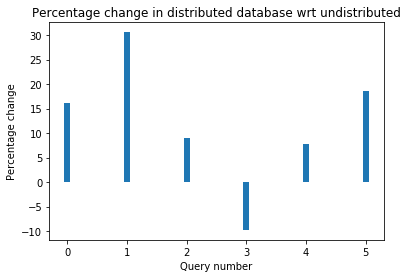

In [259]:
plt.bar(x, percentage_change_wrt_nodist, width= 0.1)
plt.title("Percentage change in distributed database wrt undistributed")
plt.xticks([0, 1,2,3,4,5])
plt.xlabel("Query number")
plt.ylabel( "Percentage change")
plt.show()


# Conclusion

#### By above queries we see, we observe that we have slight improvement in most of the queries inspite of the fact that dimension and song_plyas table contain decent number of rows. Therefore, we can go forward with our dist schema style to implement in our project `etl.py`.

<b><font color='red'>DO NOT RUN THIS UNLESS YOU ARE SURE <br/> </b>

# Clean up your resources

In [ ]:
#### CAREFUL!!
#-- Uncomment & run to delete the created resources
#redshift.delete_cluster( ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,  SkipFinalClusterSnapshot=True)
#### CAREFUL!!

##### run the below block several times until the cluster really deleted

In [ ]:
redshift.describe_clusters()

In [ ]:
#### CAREFUL!!
#-- Uncomment & run to delete the created resources
#iam.detach_role_policy(RoleName=DWH_IAM_ROLE_NAME, PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess")
#iam.delete_role(RoleName=DWH_IAM_ROLE_NAME)
#### CAREFUL!!